In [1]:
import numba
import numpy as np
import matplotlib.pyplot as plt

from typing import List
from numba.experimental import jitclass

from numba import int64, float64    # import the types

In [53]:
@numba.jit(nopython=True)
def lift(x, i, offset, vals):
    v = x[i + offset] * vals[0]
    if len(vals) > 1:
        return v + lift(x, i, offset + 1, vals[1:])
    else:
        return v

@numba.jit(nopython=True)
def lift_wrap(x, i, n, offset, vals):
    io = i + offset
    if (io < 0):
        io = n + io
    elif(io >= n):
        io = io - n
    v = x[io] * vals[0]
    if len(vals) > 1:
        return v + lift_wrap(x, i, n, offset + 1, vals[1:])
    else:
        return v

@numba.jit(nopython=True)
def lift_zero(x, i, n, offset, vals):
    io = i + offset
    if io >= n:
        return x.dtype.type(0.0)
    elif io < 0:
        return lift_zero(x, i, n, offset + 1, vals[1:])
    
    v = x[io] * vals[0]
    if len(vals) > 1:
        return v + lift_zero(x, i, n, offset + 1, vals[1:])
    else:
        return v

@numba.jit(nopython=True)
def lift_const(x, i, n, offset, vals):
    io = i + offset
    if io > n - 1:
        io = n-1
    elif io < 0:
        io = 0
    
    v = x[io] * vals[0]
    if len(vals) > 1:
        return v + lift_const(x, i, n, offset + 1, vals[1:])
    else:
        return v

In [54]:
@numba.jit(nopython=True)
def lift_symm(x, i, n, offset, vals):
    io = i + offset
    if io >= n:
        io = n - 1 - (io - n)
    elif io < 0:
        io = -(io + 1)

    v = x[io] * vals[0]
    if len(vals) > 1:
        return v + lift_symm(x, i, n, offset + 1, vals[1:])
    else:
        return v

@numba.jit(nopython=True)
def lift_refl(x, i, n, offset, vals):
    io = i + offset
    if io >= n:
        io = n - 2 - (io - n)
    elif io < 0:
        io = -io

    v = x[io] * vals[0]
    if len(vals) > 1:
        return v + lift_refl(x, i, n, offset + 1, vals[1:])
    else:
        return v

In [ ]:

@jitclass
class update_s:
    offset: int
    vals: float64[:]

    n_front: int
    n_back: int

    offset_r: int
    vals_r: float64[:]

    n_front_r: int
    n_back_r: int

    def __init__(self, offset, vals):
        self.vals = np.asarray(vals, dtype=np.float64).copy()
        self.offset = offset
        self.n_front = 0 if offset > 0 else -offset

        n_vals = len(vals)
        max_off = n_vals - 1 + offset
        self.n_back = 0 if max_off < 0 else max_off

        self.vals_r = np.asarray(vals[::-1], dtype=np.float64).copy()
        self.offset_r = -max_off
        self.n_front_r = 0 if self.offset_r > 0 else -self.offset_r
        
        max_off_r = n_vals - 1 + self.offset_r
        self.n_back_r = 0 if max_off_r < 0 else max_off_r

    def forward(self, s, d, bc_wrap) -> None:
        ns = len(s)
        nd = len(d)
        vals = self.vals.astype(s.dtype)

        for i in range(self.n_front):
            s[i] += bc_wrap(d, i, nd, self.offset, vals)
    
        for i in range(self.n_front, nd - self.n_back):
            s[i] += lift(d, i, self.offset, vals)
    
        for i in range(nd - self.n_back, ns):
            s[i] += bc_wrap(d, i, nd, self.offset, vals)

    def forward_adj(self, s, d, bc_wrap) -> None:
        ns = len(s)
        nd = len(d)
        vals = self.vals_r.astype(s.dtype)
        
        for i in range(self.n_front_r):
           d[i] += bc_wrap(s, i, ns, nd, self.offset_r, vals)
    
        for i in range(self.n_front_r, nd - self.n_back):
            d[i] += lift(s, i, self.offset_r, vals)
    
        for i in range(nd - self.n_back, nd):
           d[i] += bc_wrap(s, i, ns, nd, self.offset, vals)

    def inverse(self, s, d, bc_wrap) -> None:
        ns = len(s)
        nd = len(d)
        vals = self.vals.astype(s.dtype)

        for i in range(self.n_front):
            s[i] -= bc_wrap(d, i, nd, self.offset, vals)
    
        for i in range(self.n_front, nd - self.n_back):
            s[i] -= lift(d, i, self.offset, vals)
    
        for i in range(nd - self.n_back, ns):
            s[i] -= bc_wrap(d, i, nd, self.offset, vals)

    def inverse_adj(self, s, d, bc_wrap) -> None:
        ns = len(s)
        nd = len(d)
        vals = self.vals_r.astype(s.dtype)
        
        for i in range(self.n_front_r):
            d[i] -= bc_wrap(s, i, ns, nd, self.offset_r, vals)
    
        for i in range(self.n_front_r, nd - self.n_back):
            d[i] -= lift(s, i, self.offset_r, vals)
    
        for i in range(nd - self.n_back, nd):
            d[i] -= bc_wrap(s, i, ns, nd, self.offset_r, vals)

@jitclass
class scale:
    sc: float

    def __init__(self, sc: float):
        self.sc = sc

    def forward(self, s, d, bc_wrap) -> None:
        sc = s.dtype.type(self.sc)
        s *= sc
        d /= sc

    def inverse(self, s, d, bc_wrap) -> None:
        sc = s.dtype.type(self.sc)
        s /= sc
        d *= sc

    forward_adj = forward
    inverse_adj = inverse

In [137]:
# class db7:
#     s1_p0 = 5.09349848430361493158448369309319682065288729718818488170086
#     s2_m0 = -0.189042092071992120719115069286184373462757526526706607687359
#     s2_m1 =  0.0573987259809472316318163158166229520747344869480313379225195
#     s3_p1 = -12.2854449967343086359903552773950797906521905606178682213636
#     s3_p2 =   5.95920876247802982415703053009457554606483451817620285866937
#     s4_m2 = -0.0604278631317421373037302780741631438456816254617632977400450
#     s4_m3 =  0.0291354832120604111715672746297275711217338322811099054777142
#     s5_p3 = -3.97071066749950430300434793946545058865144871092579097855408
#     s5_p4 = 1.56044025996325478842482192099426071408509934413107380064471
#     s6_m4 = -0.0126913773899277263576544929765396597865052704453285425832652
#     s6_m5 = 0.00330657330114293172083753191386779325367868962178489518206046
#     s7_p5 = -0.414198450444716993956500507305024397477047469411911796987340
#     s7_p6 = 0.0508158836433382836486473921674908683852045493076552967984957
#     s8_m6 = -0.000406214488767545513490343915060150692174820527241063790923

#     sc = 0.299010707585297416977548850152193565671577389737970684943879

#     steps = (
#         update_s( 0, [s1_p0]),
#         update_d(-1, [s2_m1, s2_m0]),
#         update_s( 1, [s3_p1, s3_p2]),
#         update_d(-3, [s4_m3, s4_m2]),
#         update_s( 3, [s5_p3, s5_p4]),
#         update_d(-5, [s6_m5, s6_m4]),
#         update_s( 5, [s7_p5, s7_p6]),
#         update_d(-6, [s8_m6]),
#         scale(sc)
#     )

# class db7_r:
#     s1_m0 = -5.09349848430361493158448369309319682065288729718818488170086
#     s2_p0 = 0.189042092071992120719115069286184373462757526526706607687359
#     s2_p1 =  -0.0573987259809472316318163158166229520747344869480313379225195
#     s3_m1 = 12.2854449967343086359903552773950797906521905606178682213636
#     s3_m2 =  -5.95920876247802982415703053009457554606483451817620285866937
#     s4_p2 = 0.0604278631317421373037302780741631438456816254617632977400450
#     s4_p3 =  -0.0291354832120604111715672746297275711217338322811099054777142
#     s5_m3 = 3.97071066749950430300434793946545058865144871092579097855408
#     s5_m4 = -1.56044025996325478842482192099426071408509934413107380064471
#     s6_p4 = 0.0126913773899277263576544929765396597865052704453285425832652
#     s6_p5 = -0.00330657330114293172083753191386779325367868962178489518206046
#     s7_m5 = 0.414198450444716993956500507305024397477047469411911796987340
#     s7_m6 = -0.0508158836433382836486473921674908683852045493076552967984957
#     s8_p6 = 0.000406214488767545513490343915060150692174820527241063790923

#     sc = 1/0.299010707585297416977548850152193565671577389737970684943879

#     steps = (
#         update_d( 0, [s1_m0]),
#         update_s( 0, [s2_p0, s2_p1]),
#         update_d(-2, [s3_m2, s3_m1]),
#         update_s( 2, [s4_p2, s4_p3]),
#         update_d(-4, [s5_m4, s5_m3]),
#         update_s( 4, [s6_p4, s6_p5]),
#         update_d(-6, [s7_m6, s7_m5]),
#         update_s( 6, [s8_p6]),
#         scale(sc)
#     )

# class BiorSpline6_2:
#     s1 = -0.166666666666666666666666666666666666666666666666666666666667
#     s2 = -0.5625
#     s3 = -1.33333333333333333333333333333333333333333333333333333333333
#     s4 = 0.15625
#     sc = 5.65685424949238019520675489683879231427868750150779229270672

#     steps = (
#         update_d(-2, [-2, -4, -6, -8, -10, -12, -14]),
#         # update_s(-1, [s2, s2]),
#         # update_d(0, [s3, s3]),
#         # update_s(-1, [s4, s4]),
#         # scale(sc),
#     )

# class ReverseBiorSpline6_2:
#     s1 = 0.166666666666666666666666666666666666666666666666666666666667
#     s2 = 0.5625
#     s3 = 1.33333333333333333333333333333333333333333333333333333333333
#     s4 = -0.15625
#     sc = 1/5.65685424949238019520675489683879231427868750150779229270672

#     steps = (
#         update_s(-2, [s1, s1, s1, s1, s1]),
#         # update_d(0, [s2, s2]),
#         # update_s(-1, [s3, s3]),
#         # update_d(0, [s4, s4]),
#         # scale(sc),
#     )
    

In [145]:
@jitclass
class update_d:
    offset: int
    vals: float64[:]

    n_front: int
    n_back: int

    offset_r: int
    vals_r: float64[:]

    n_front_r: int
    n_back_r: int
    
    def __init__(self, offset, vals):
        self.vals = np.asarray(vals, dtype=np.float64).copy()
        self.offset = offset
        self.n_front = 0 if offset > 0 else -offset

        n_vals = len(vals)
        max_off = n_vals - 1 + offset
        self.n_back = 0 if max_off < 0 else max_off

        self.vals_r = np.asarray(vals[::-1], dtype=np.float64).copy()
        self.offset_r = -max_off
        self.n_front_r = 0 if self.offset_r > 0 else -self.offset_r
        
        max_off_r = n_vals - 1 + self.offset_r
        self.n_back_r = 0 if max_off_r < 0 else max_off_r

    def forward(self, s, d, bc_wrap) -> None:
        ns = len(s)
        nd = len(d)
        vals = self.vals.astype(s.dtype)
        
        for i in range(self.n_front):
            d[i] += bc_wrap(s, i, ns, self.offset, vals)
    
        for i in range(self.n_front, nd - self.n_back):
            d[i] += lift(s, i, self.offset, vals)
    
        for i in range(nd - self.n_back, nd):
            d[i] += bc_wrap(s, i, ns, self.offset, vals)

    def forward_adj(self, s, d, bc_wrap) -> None:
        ns = len(s)
        nd = len(d)
        vals = self.vals_r.astype(s.dtype)
        
        for i in range(self.n_front_r):
            s[i] += lift_zero(d, i, nd, self.offset_r, vals)
    
        for i in range(self.n_front_r, nd - self.n_back_r):
            s[i] += lift(d, i, self.offset_r, vals)
    
        for i in range(nd - self.n_back_r, ns):
            s[i] += lift_zero(d, i, nd, self.offset_r, vals)

    def inverse(self, s, d, bc_wrap) -> None:
        ns = len(s)
        nd = len(d)
        vals = self.vals.astype(s.dtype)
        
        for i in range(self.n_front):
            d[i] -= bc_wrap(s, i, ns, self.offset, self.vals)
    
        for i in range(self.n_front, nd - self.n_back):
            d[i] -= lift(s, i, self.offset, self.vals)
    
        for i in range(nd - self.n_back, nd):
            d[i] -= bc_wrap(s, i, ns, self.offset, self.vals)

    def inverse_adj(self, s, d, bc_wrap) -> None:
        ns = len(s)
        nd = len(d)
        vals = self.vals_r.astype(s.dtype)

        for i in range(self.offset, 0):
            ii, v = bc_wrap(d, i, nd, ns, self.offset_r, vals)
            s[ii] -= v
        
        for i in range(self.n_front_r):
            s[i] -= lift_zero(d, i, nd, self.offset_r, vals)
    
        for i in range(self.n_front_r, nd - self.n_back_r):
            s[i] -= lift(d, i, self.offset_r, vals)
    
        for i in range(nd - self.n_back_r, ns):
            s[i] -= lift_zero(d, i, nd, ns, self.offset_r, vals)

        for i in range(ns, ns + len(self.vals) + self.offset):
            ii, v = bc_wrap(d, i, nd, ns, self.offset_r, vals)
            s[ii] -= v


In [136]:
def forward_transform(wvlt, x, mode="periodic"):
    if mode == 'periodic':
        bc_wrap = lift_wrap
    elif mode == 'zero':
        bc_wrap = lift_zero
    elif mode == 'constant':
        bc_wrap = lift_const
    elif mode == 'symmetric':
        bc_wrap = lift_symm
    elif mode == 'reflect':
        bc_wrap = lift_refl
    s = x[::2].copy()
    d = x[1::2].copy()

    for step in wvlt.steps:
        step.forward(s, d, bc_wrap)

    return s, d

def inverse_transform(wvlt, s, d, mode="periodic"):
    if mode == 'periodic':
        bc_wrap = lift_wrap
    elif mode == 'zero':
        bc_wrap = lift_zero
    elif mode == 'constant':
        bc_wrap = lift_const
    elif mode == 'symmetric':
        bc_wrap = lift_symm
    elif mode == 'reflect':
        bc_wrap = lift_refl
    
    s = s.copy()
    d = d.copy()

    for step in wvlt.steps[::-1]:
        step.inverse(s, d, bc_wrap)

    x = np.empty(len(s) + len(d), dtype=s.dtype)
    x[::2] = s
    x[1::2] = d
    return x

In [ ]:
# class BiorSpline6_2:
#     s1 = -0.166666666666666666666666666666666666666666666666666666666667
#     s2 = -0.5625
#     s3 = -1.33333333333333333333333333333333333333333333333333333333333
#     s4 = 0.15625
#     sc = 5.65685424949238019520675489683879231427868750150779229270672

#     steps = (
#         update_d(-2, [-2, -4, -6, -8, -10, -12, -14]),
#         # update_s(-1, [s2, s2]),
#         # update_d(0, [s3, s3]),
#         # update_s(-1, [s4, s4]),
#         # scale(sc),
#     )

In [138]:
@numba.jit(nopython=True)
def lift_zero_adj(x, i, nx, ny, offset, vals):
    return x.dtype.type(0)

@numba.jit(nopython=True)
def lift_wrap_adj(x, i, nx, ny, offset, vals):
    n_vals = len(vals)
    io = i + offset
    if (io < 0):
        io = ny + io
    elif(io >= ny):
        io = io - ny
    if io >= nx:
        if len(vals) > 1:
            return lift_wrap_adj(x, i, nx, ny, offset + 1, vals[1:])
        else:
            return x.dtype.type(0.0)
    v = x[io] * vals[0]
    if len(vals) > 1:
        return v + lift_wrap_adj(x, i, nx, ny, offset + 1, vals[1:])
    else:
        return v

@numba.jit(nopython=True)
def lift_const_adj(x, i, nx, ny, offset, vals):
    n_vals = len(vals)
    io = i + offset
    if i == ny - 1:
        v = x.dtype.type(0)
        j = 0
        cum_sum = x.dtype.type(0)
        for ii in range(io, nx):
            v += (cum_sum + vals[j]) * x[ii]
            cum_sum += vals[j]
            j += 1
        return v
    if i == 0:
        j = n_vals - 1
        v = x.dtype.type(0)
        cum_sum = x.dtype.type(0)
        for ii in range(io + n_vals - 1, -1, -1):
            v += (cum_sum + vals[j]) * x[ii]
            cum_sum += vals[j]
            j -= 1
        return v
    else:
        if len(vals) == 0:
            return x.dtype.type(0)

        if io < 0 or io >= nx:
            return lift_const_adj(x, i, nx, ny, offset+1, vals[1:])
        else:
            return vals[0] * x[io] + lift_const_adj(x, i, nx, ny, offset+1, vals[1:])

@numba.jit(nopython=True)
def lift_symm_adj(x, i, nx, ny, offset, vals):
    
    return x.dtype.type(0)
    if i < nx - (n_vals + offset - 1):
        pass
    else:
        pass
        
        
    io = i + offset
    if io >= nx:
        return x.dtype.type(0)
    elif io < 0:
        io = -(io + 1)

    v = x[io] * vals[0]
    if len(vals) > 1:
        return v + lift_symm_adj(x, i, nx, ny, offset + 1, vals[1:])
    else:
        return v

(26, (22, 22), (18, 18, 18), (14, 14, 14, 14))

In [140]:
# @ i = n + offset:

In [141]:
def forward_adjoint(wvlt, s, d, mode="periodic"):
    if mode == 'periodic':
        bc_wrap = lift_wrap_adj
    elif mode == 'zero':
        bc_wrap = lift_zero_adj
    elif mode == 'constant':
        bc_wrap = lift_const_adj
    elif mode == 'symmetric':
        bc_wrap = lift_symm_adj
    elif mode == 'reflect':
        bc_wrap = lift_refl
    
    s = s.copy()
    d = d.copy()

    for step in wvlt.steps[::-1]:
        step.forward_adj(s, d, bc_wrap)

    x = np.empty(len(s) + len(d), dtype=s.dtype)
    x[::2] = s
    x[1::2] = d
    return x

def inverse_adjoint(wvlt, x, mode="periodic"):
    if mode == 'periodic':
        bc_wrap = lift_wrap_adj
    elif mode == 'zero':
        bc_wrap = lift_zero_adj
    elif mode == 'constant':
        bc_wrap = lift_const_adj
    elif mode == 'symmetric':
        bc_wrap = lift_symm_adj
    elif mode == 'reflect':
        bc_wrap = lift_refl
    s = x[::2].copy()
    d = x[1::2].copy()

    for step in wvlt.steps:
        step.inverse_adj(s, d, bc_wrap)

    return s, d

In [142]:
mode='symmetric'
for_mats = []
inv_mats = []
for_adj_mats = []
inv_adj_mats = []
n = 32

for i in range(n):
    e = np.zeros(n)
    e[i] = 1
    nd = len(e)//2
    ns = len(e) - nd
    es = e[:ns]
    ed = e[ns:]
    
    s, d = forward_transform(BiorSpline6_2, e, mode=mode)
    for_mats.append(np.r_[s, d])
    inv_mats.append(inverse_transform(BiorSpline6_2, es, ed, mode=mode))

    for_adj_mats.append(forward_adjoint(BiorSpline6_2, es, ed, mode=mode))
    s, d = inverse_adjoint(BiorSpline6_2, e, mode=mode)
    inv_adj_mats.append(np.r_[s, d])

for_mats = np.stack(for_mats, axis=1)
inv_mats = np.stack(inv_mats, axis=1)
for_adj_mats = np.stack(for_adj_mats, axis=1)
inv_adj_mats = np.stack(inv_adj_mats, axis=1)

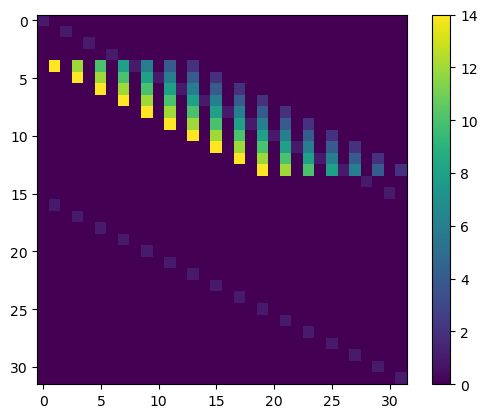

In [143]:
plt.imshow(inv_adj_mats)
plt.colorbar()

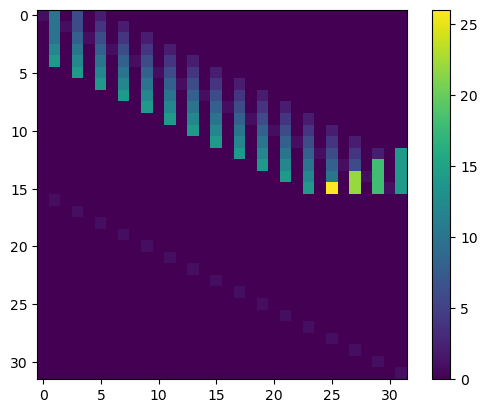

In [144]:
plt.imshow(inv_mats.T)
plt.colorbar()

In [115]:
inv_mats.T[9:16, -12:]

array([[ 0.,  4.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  6.,  0.,  4.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  8.,  1.,  6.,  0.,  4.,  0.,  2.,  0.,  0.,  0.,  0.],
       [ 0., 10.,  0.,  8.,  1.,  6.,  0.,  4.,  0.,  2.,  0., 14.],
       [ 0., 12.,  0., 10.,  0.,  8.,  1.,  6.,  0., 18.,  0., 14.],
       [ 0., 14.,  0., 12.,  0., 10.,  0., 22.,  1., 18.,  0., 14.],
       [ 0.,  0.,  0., 14.,  0., 26.,  0., 22.,  0., 18.,  1., 14.]])

In [116]:
np.round(inv_adj_mats[9:16, -12:])

array([[ 0.,  4.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  6.,  0.,  4.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  8.,  1.,  6.,  0.,  4.,  0.,  2.,  0.,  0.,  0.,  0.],
       [ 0., 10.,  0.,  8.,  1.,  6.,  0.,  4.,  0.,  2.,  0.,  0.],
       [ 0., 12.,  0., 10.,  0.,  8.,  1.,  6.,  0.,  4.,  0.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]])

In [50]:
n = 32
ps = np.linspace(-10, 10, n)

x = np.sin(ps)

In [58]:
mode = 'constant'
sx, dx = forward_transform(BiorSpline6_2, x, mode=mode)
x_inv = inverse_transform(BiorSpline6_2, sx, dx, mode=mode)
np.allclose(x, x_inv)

sx_a, dx_a = inverse_adjoint(BiorSpline6_2, x, mode=mode)
x_inv_a = forward_adjoint(BiorSpline6_2, sx_a, dx_a, mode=mode)
np.allclose(x, x_inv_a)

True

In [59]:
np.sqrt(sx @ sx_a + dx @ dx_a), np.linalg.norm(x)

(np.float64(3.897361829569374), np.float64(3.8973618295693737))

NameError: name 'sxr' is not defined

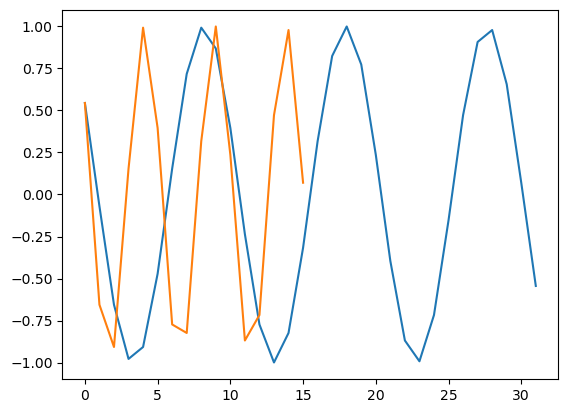

In [133]:
plt.plot(x, label='x')

plt.plot(sx, label='sx')
plt.plot(sxr, label='sxr')

plt.plot(dx, label='dx')
plt.plot(dxr, label='dxr')
plt.legend()

In [134]:
mode = 'periodic'
sy, dy = forward_transform(db7_r, y, mode=mode)
y_inv = inverse_transform(db7_r, sy, dy, mode=mode)
np.allclose(y, y_inv)

NameError: name 'y' is not defined

In [135]:
np.linalg.norm(np.r_[sy, dy]), np.linalg.norm(y)

NameError: name 'sy' is not defined

In [164]:
sx @ sy + dx @ dy, x @ y

(np.float64(-410.70579673868895), np.float64(-412.4131016924517))

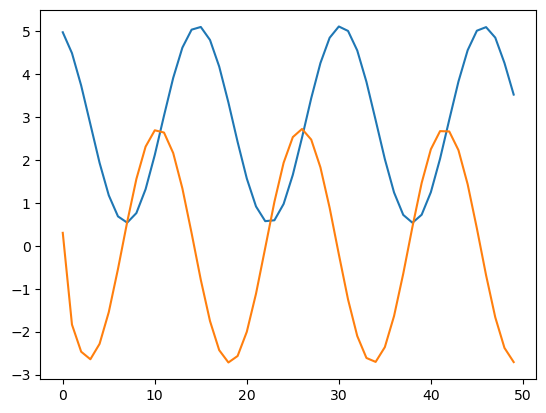

In [68]:
plt.plot(sx)
plt.plot(dx)

In [69]:
x, x_inv

(array([2.54402111, 2.36459873, 2.17034683, 1.96916632, 1.76923992,
        1.57869936, 1.40529459, 1.25607859, 1.13712052, 1.05325882,
        1.00790444, 1.00290211, 1.03845529, 1.1131179 , 1.22385315,
        1.36615705, 1.53424159, 1.72127018, 1.9196357 , 2.12126992,
        2.31797166, 2.50174037, 2.66510151, 2.80141062, 2.90512352,
        2.97202182, 2.99938456, 2.98609877, 2.93270486, 2.84137452,
        2.7158225 , 2.56115544, 2.38366419, 2.19056796, 1.98972066,
        1.78929145, 1.59743251, 1.42194741, 1.26997377, 1.14769288,
        1.06007835, 1.01069376, 1.00154777, 1.03301238, 1.1038078 ,
        1.21105454, 1.35039049, 1.51614836, 1.7015862 , 1.89916158,
        2.10083842, 2.2984138 , 2.48385164, 2.64960951, 2.78894546,
        2.8961922 , 2.96698762, 2.99845223, 2.98930624, 2.93992165,
        2.85230712, 2.73002623, 2.57805259, 2.40256749, 2.21070855,
        2.01027934, 1.80943204, 1.61633581, 1.43884456, 1.2841775 ,
        1.15862548, 1.06729514, 1.01390123, 1.00